# EEG Eye State detection

## Authors: Ángel López Manríquez

### Objectives: Determine whether an eye is opened or closed given brain signals.
### What is done in the Notebook: Preprocessing the data and the use of several classifiers algorithms.

In [19]:

# import arff  # it doesn't work on mac ?!

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time


from IPython.display import display, HTML, Markdown

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score

# classifiers
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC  # Support vector classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from matplotlib.colors import ListedColormap


In [2]:
plt.style.use('seaborn')

## Reading the dataset

In the image shown below we apreciate where the sensor where applied in a particular brain part. 

In [3]:
filename = 'EEG.csv'
dataset = pd.read_csv('EEG.csv')
display(dataset.head())

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,0
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,0
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,0
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,0
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,0


In [4]:
from IPython.display import Image
from IPython.core.display import HTML


url = "https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2018/06/Cartoon-of-where-EEG-sensors-were-located-on-the-subject.png"
l = 400
display(Image(url=url, width=l, height=l))



## Preprocessing the data

 Display at particular time the signals of the brain and the state of the eye.

C:\Users\Sigma\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  if sys.path[0] == '':


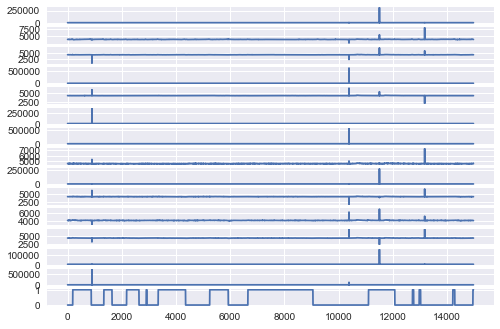

In [5]:
values = dataset.values

# sc = StandardScaler()
# X = sc.fit_transform(X)

def plot_eeg(values):
    # create a subplot for each time series
    plt.figure()
    for i in range(values.shape[1]):
        plt.subplot(values.shape[1], 1, i+1)
        plt.plot(values[:, i])
    plt.tight_layout()
    plt.show()
    
plot_eeg(values)

We appreciate in the plot the data might be quite "outlied" so we process the dataset and we visualize the results given.

In [6]:

# remove outliers from the EEG data
from numpy import mean, std, delete, savetxt

filename_no_outliers = filename.replace('.', 'NoOutliers.')

def remove_outliers_to_file(values):
    # step over each EEG column
    for i in range(values.shape[1] - 1):
        data_mean, data_std = mean(values[:,i]), std(values[:,i])
        cut_off = data_std * 4  # define outlier bounds
        lower, upper = data_mean - cut_off, data_mean + cut_off
        too_small = [j for j in range(values.shape[0]) if values[j,i] < lower]
        values = delete(values, too_small, 0)
        print('->deleted %d rows' % len(too_small))
        too_large = [j for j in range(values.shape[0]) if values[j,i] > upper]
        values = delete(values, too_large, 0)
        print('->deleted %d rows' % len(too_large))

    # save the results to a new file
    savetxt(filename_no_outliers, values, delimiter=',')
    
remove_outliers_to_file(values)

->deleted 0 rows
->deleted 2 rows
->deleted 0 rows
->deleted 0 rows
->deleted 0 rows
->deleted 0 rows
->deleted 0 rows
->deleted 0 rows
->deleted 0 rows
->deleted 10 rows
->deleted 21 rows
->deleted 0 rows
->deleted 58 rows
->deleted 0 rows
->deleted 59 rows


C:\Users\Sigma\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  if sys.path[0] == '':


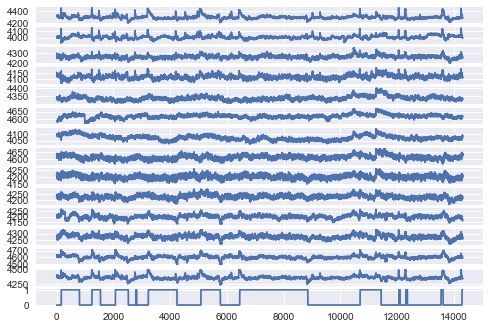

In [7]:
data = pd.read_csv(filename_no_outliers).values
plot_eeg(data)
data = np.array(data)
X = data[:, :-1]
y = data[:, -1]

# sc = StandardScaler()
# X = sc.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Testing the classifiers
We'll determine which is the most suitable model for our dataset.

In [27]:
# importing libraries 
import time 
import math 


def display_markdown(txt):
    display(Markdown(txt))

# decorator to calculate duration 
# taken by any function. 
def calculate_time(func): 
      
    # added arguments inside the inner1, 
    # if function takes any arguments, 
    # can be added like this. 
    def inner1(*args, **kwargs): 
        # storing time before function execution 
        begin = time.time() 
        func(*args, **kwargs) 
        
        # storing time after function execution 
        end = time.time() 
        print(func.__name__, "\tTotal time taken in : ", end - begin, 'seconds') 
    return inner1 



In [28]:
def plot_confusion_matrix(model, X, y, ticklabels):
    y_pred = model.predict(X)  # predict the class. Same as np.argmax(model.predict(X))
    conf_mat = confusion_matrix(y, y_pred)  # create the confusion matrix

    # create the plot
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d',
              xticklabels=ticklabels, yticklabels=ticklabels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    print('Accuracy score: ', accuracy_score(y, y_pred))
    
@calculate_time
def classifier_summary(clf, name, X_train, X_test, y_train, y_test, latex=False):
    '''clf: Classifier, name: str '''
    clf.fit(X_train, y_train)
    display_markdown(f'## {name}')
    plot_confusion_matrix(clf, X_test, y_test, ['0', '1'])
#     y_pred = clf.predict(X_test)
#     print(accuracy_score(y_test, y_pred))
#     cm = pd.crosstab(y_test, y_pred)
#     if latex: print(cm.to_latex())
#     display(cm)

In [29]:


pe = Perceptron(max_iter=1000, tol=1e-3, eta0=0.1)
lg = LogisticRegression(random_state=0)
gnb = GaussianNB()
knc = KNeighborsClassifier(n_neighbors=100)
dtc = DecisionTreeClassifier(random_state=0)
rfc = RandomForestClassifier(random_state=0)


C:\Users\Sigma\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Logistic "Regression"

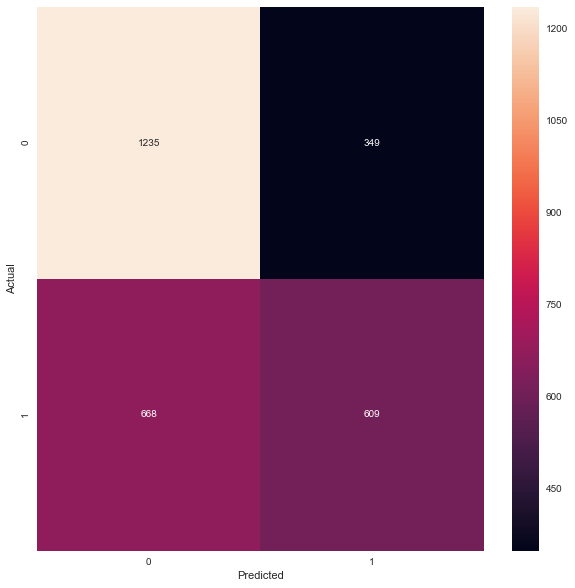

Accuracy score:  0.6445298846557148
classifier_summary 	Total time taken in :  0.19148588180541992 seconds


## Naive bayes (Gaussian)

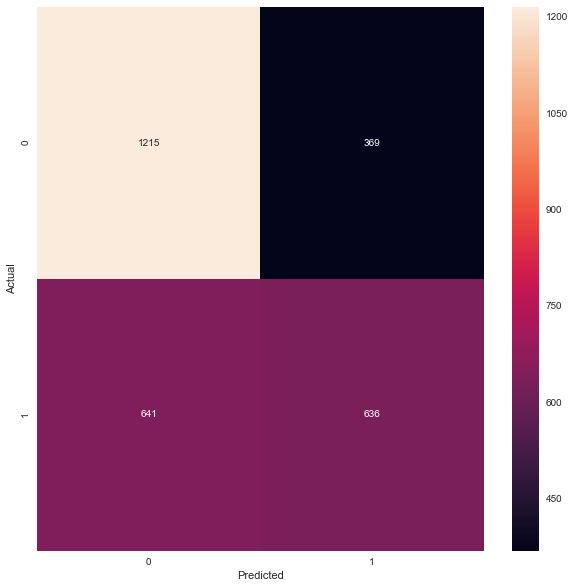

Accuracy score:  0.64697658161482
classifier_summary 	Total time taken in :  0.15268349647521973 seconds


## KNeighbors classifier

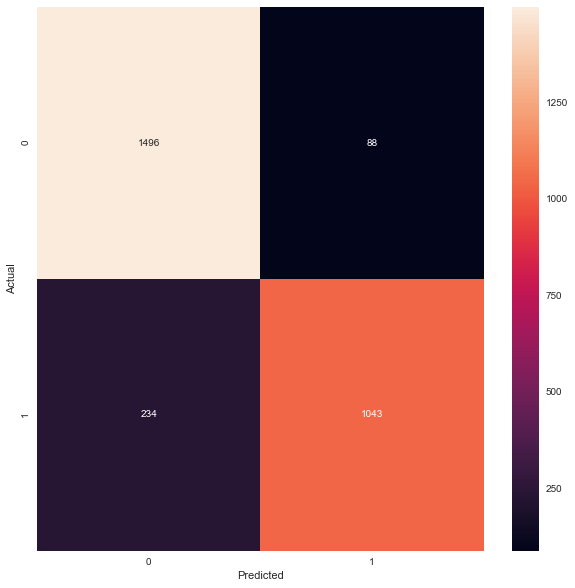

Accuracy score:  0.8874519398811604
classifier_summary 	Total time taken in :  0.8041324615478516 seconds


## Perceptron

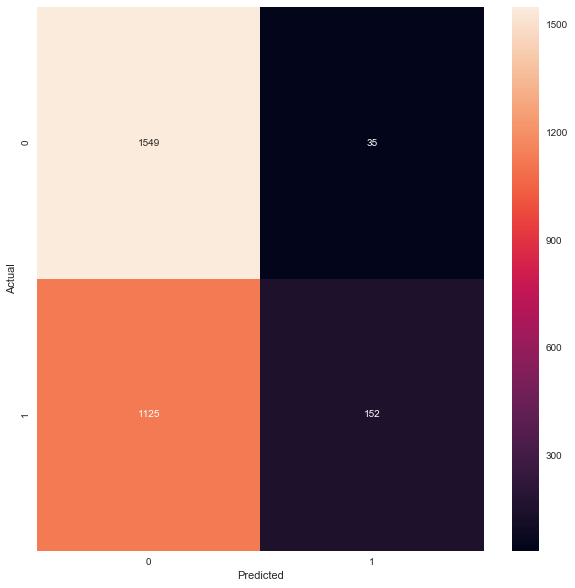

Accuracy score:  0.5945473610625656
classifier_summary 	Total time taken in :  0.2423853874206543 seconds


## Decision Tree Classifier

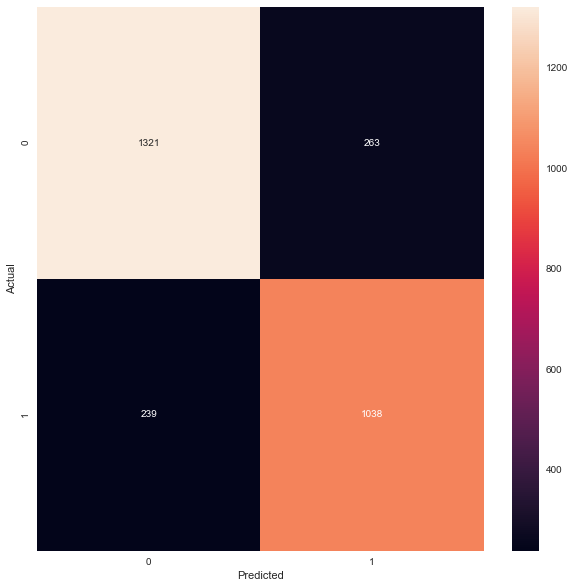

Accuracy score:  0.8245368752184551
classifier_summary 	Total time taken in :  0.22757720947265625 seconds


C:\Users\Sigma\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## Random forest classifier

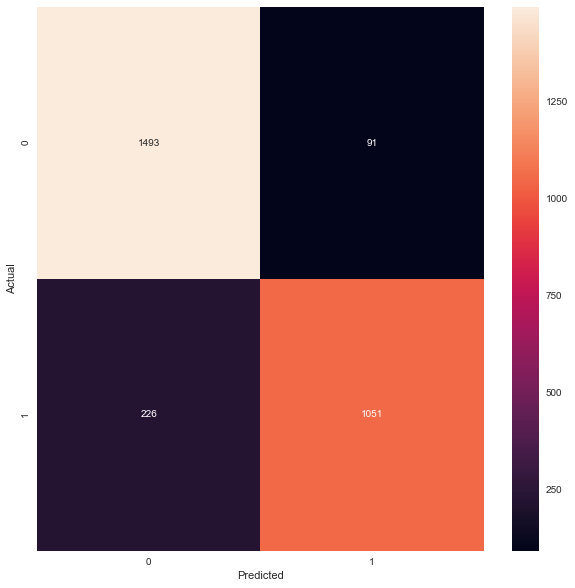

Accuracy score:  0.8891995805662356
classifier_summary 	Total time taken in :  0.5127074718475342 seconds


In [30]:
for clf, name in ((lg,'Logistic "Regression"'), (gnb,'Naive bayes (Gaussian)'), 
                  (knc,'KNeighbors classifier'), (pe, 'Perceptron'),
                  (dtc,'Decision Tree Classifier'), (rfc, 'Random forest classifier'), ):
    classifier_summary(clf, name, X_train, X_test, y_train, y_test)              
